### Q1

Given a general regression model in matrix form:\
$y = X\beta + \epsilon$

We want to find the OLS estimators given by the vector $\beta$ such that we minimise the sum of squared residuals (SSR):\
$SSR = (y - X\beta)^T(y - X\beta)$

Expand the SSR:\
$SSR = y^T y - 2\beta^T X^T y + \beta^T X^T X \beta$

Since this is a linear equation, we can differentiate each part independently:\
$\frac{\partial}{\partial \beta}(y^T y) = 0$\
$\frac{\partial}{\partial \beta}(-2\beta^T X^T y) = -2 X^T y$\
$\frac{\partial}{\partial \beta}(\beta^T X^T X \beta) = 2 X^T X \beta$

Therefore the derivative of the SSR wrt to $\beta$ is:\
$\frac{\partial RSS}{\partial \beta} = -2 X^T y + 2 X^T X \beta$

Which we then set to $0$ to find the mininum SSR:\
$-2 X^T y + 2 X^T X \beta = 0$

Solving for $\beta$:\
$X^T X \beta = X^T y$\
$\beta = (X^T X)^{-1} X^T y$

Substitute the values from the specific model:\
$y = \beta_0 \cdot \iota + \epsilon$\
$\begin{bmatrix}
\beta_0
\end{bmatrix}
= (\iota^T \iota)^{-1} \iota^T y$

$(\iota^T \iota)$ will sum over the $n$ elements of $\iota$, and\
$(\iota^T \iota)^{-1}$ will be the reciprocal of that sum, or $\frac{1}{n}$.\
$\iota^T y$ will sum over the elements of $y$.

Therefore:\
$\beta_0 = \frac{1}{n} \sum_{i=1}^n y_i = \bar{y}$

### Q2

### Q3

#### Imports

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
from patsy import dmatrix
import statsmodels.api as sm

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#### Data

In [ ]:
# Load the CSV file into a DataFrame
data = pd.read_csv('vixlarge.csv')

# DATE column should be in datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# We need numeric ordinal format for spline basis
data['DATE_ordinal'] = data['DATE'].map(pd.Timestamp.toordinal)

# Just for fun, let's overfit the data
# Calculate absolute differences to find regions of high variability
data['VIX_diff'] = data['VIX'].diff().abs()

#### Hyperparameters

In [53]:
# Cubic Spline
num_knots = 5

# Lasso
lasso_lambda_1 = 1
lasso_lambda_2 = 10

# Ridge
ridge_lambda_1 = 1
ridge_lambda_2 = 10

# Rolling Window
window_length = 3000

(a) Plot the VIX data against date in line. Clearly label the horizontal and vertical axes

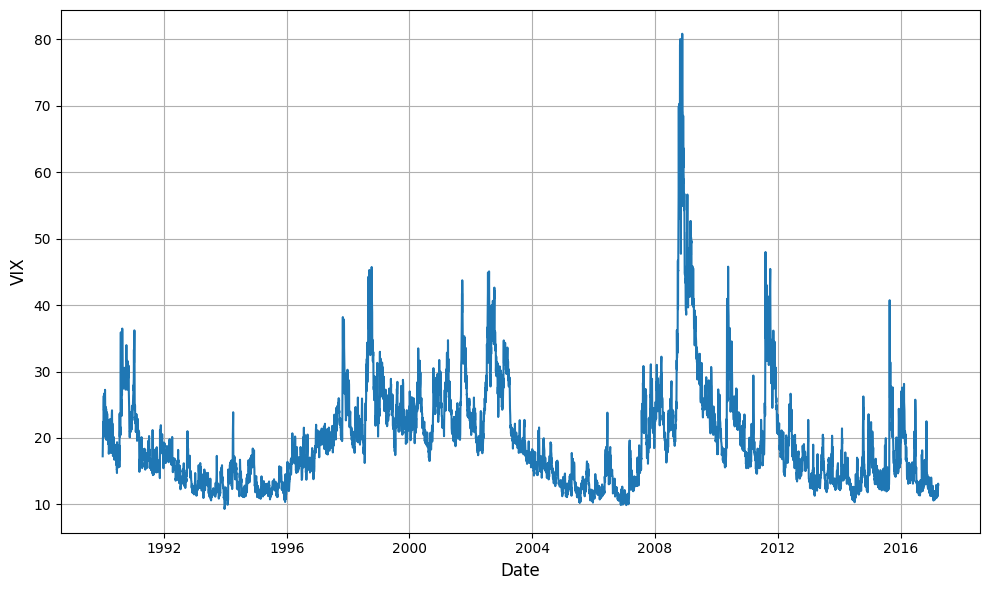

In [25]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['VIX'])

# Label the axes and add a title
plt.xlabel('Date', fontsize=12)
plt.ylabel('VIX', fontsize=12)

# Add grid and legend
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

(b) Pick 5 nodes and fit the data using one of the regression splines. State the method you choose clearly and show the plot.

The method we will be using the natural cubic spline.

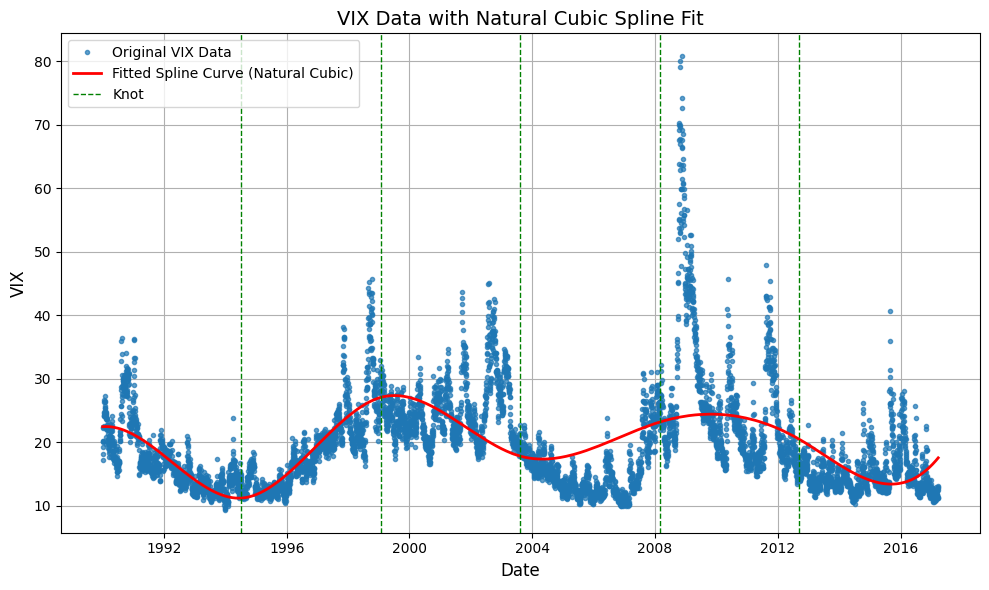

In [47]:
# Create 7 evenly spaced indices, then remove the two boundary indices
knot_indices = np.linspace(0, len(data) - 1, num=num_knots + 2, dtype=int)[1:-1]

# Get dates corresponding to the knots
knot_dates = data['DATE'].iloc[knot_indices].tolist()
knot_values = data['DATE_ordinal'].iloc[knot_indices].tolist()

# Generate spline basis functions
spline_basis = dmatrix(
  f"bs(DATE_ordinal, knots={knot_values}, degree=3, include_intercept=True)",
  {"DATE_ordinal": data['DATE_ordinal']},
  return_type="dataframe"
)

# Fit the OLS model
model = sm.OLS(data['VIX'], spline_basis).fit()
data['VIX_fitted'] = model.fittedvalues

# Plot the fitted curve along with the original data
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['VIX'], 'o', label='Original VIX Data', markersize=3, alpha=0.7)
plt.plot(data['DATE'], data['VIX_fitted'], label='Fitted Spline Curve (Natural Cubic)', color='red', linewidth=2)

# Mark the knots on the plot
for knot_date in knot_dates:
  plt.axvline(x=knot_date, color='green', linestyle='--', linewidth=1, label="Knot" if 'Knot' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel("Date", fontsize=12)
plt.ylabel("VIX", fontsize=12)
plt.title("VIX Data with Natural Cubic Spline Fit", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [48]:
# Calculate R-squared
r2 = r2_score(data['VIX'], data['VIX_fitted'])
print(f"R^2 (Coefficient of Determination): {r2:.4f}")

R^2 (Coefficient of Determination): 0.3162


We can improve R^2 by tweaking knot positions:

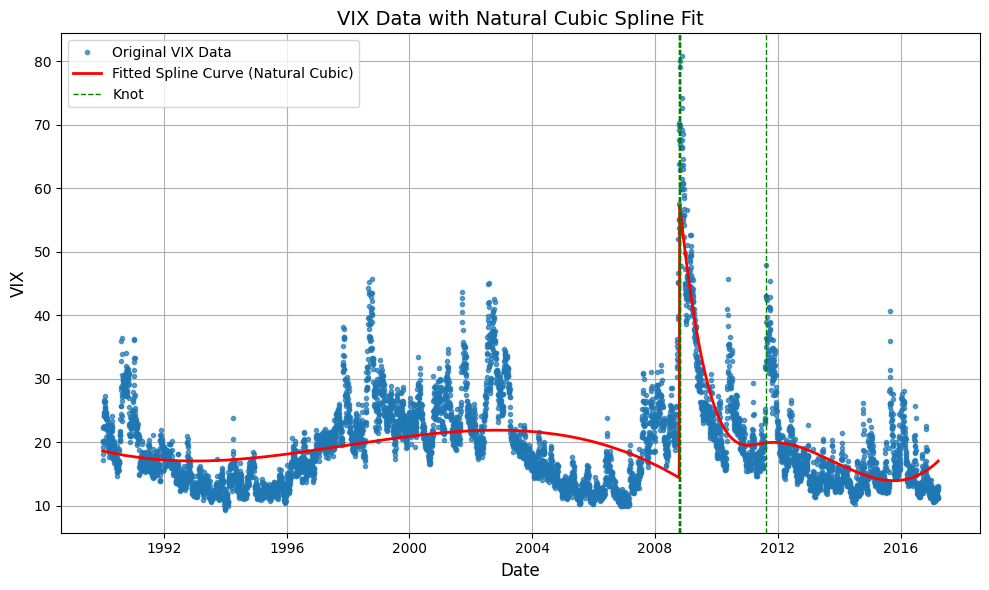

In [49]:
# Select top N regions with highest variability for knot placement
knot_indices = data['VIX_diff'].nlargest(num_knots).index
knot_values = data['DATE_ordinal'].iloc[knot_indices].tolist()
knot_dates = data['DATE'].iloc[knot_indices].tolist()

# Generate spline basis functions with these custom knots
spline_basis = dmatrix(
    f"bs(DATE_ordinal, knots={knot_values}, degree=3, include_intercept=True)",
    {"DATE_ordinal": data['DATE_ordinal']},
    return_type="dataframe"
)

# Fit the OLS model
model = sm.OLS(data['VIX'], spline_basis).fit()
data['VIX_fitted'] = model.fittedvalues

# Plot the fitted curve along with the original data
plt.figure(figsize=(10, 6))
plt.plot(data['DATE'], data['VIX'], 'o', label='Original VIX Data', markersize=3, alpha=0.7)
plt.plot(data['DATE'], data['VIX_fitted'], label='Fitted Spline Curve (Natural Cubic)', color='red', linewidth=2)

# Mark the knots on the plot
for knot_date in knot_dates:
  plt.axvline(x=knot_date, color='green', linestyle='--', linewidth=1, label="Knot" if 'Knot' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.xlabel("Date", fontsize=12)
plt.ylabel("VIX", fontsize=12)
plt.title("VIX Data with Natural Cubic Spline Fit", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# Calculate R-squared
r2 = r2_score(data['VIX'], data['VIX_fitted'])
print(f"R^2 (Coefficient of Determination): {r2:.4f}")

R^2 (Coefficient of Determination): 0.3946


But this is very obviously an overfit.

(c) Let the dependent variable y be the VIX and the first and the second columns
of the independent variable X be the intercept term and the lag of VIX (set x0 = 0).
Conduct a one-step-ahead rolling window exercise.

The following code combines (i), (ii), (iii), and (iv).

In [79]:
# Data
# We need to regress on lagged data
data['VIX_lag'] = data['VIX'].shift(1)
data.dropna(inplace=True) # Prevent models from complaining about NaN introduced by shift

# Variables
horizons = [1]
results_list = []

# Loop through forecast horizons
for h in horizons:
  lead_col = f'VIX_lead_{h}'
  # We need to predict future data
  data[lead_col] = data['VIX'].shift(-h)
  data.dropna(inplace=True) # Prevent models from complaining about NaN introduced by shift
  
  # Create a design matrix
  X_lin = np.column_stack([
    np.ones(len(data)),      # intercept
    data['VIX_lag'].values   # predictor
  ])
  
  y_all = data[lead_col].values 
  n = len(y_all)
  
  # Create variables
  preds_lasso_1  = []
  preds_lasso_2  = []
  preds_ridge_1  = []
  preds_ridge_2  = []
  actual_vals  = []
  
  # Loop through rolling windows
  # Basically keep sliding the rolling window one index over until
  # The right edge of the rolling window hits the end of the array
  for start_idx in range(n - window_length):
    end_idx = start_idx + window_length
    
    # Training sets
    X_train_lin = X_lin[start_idx : end_idx, :]
    y_train     = y_all[start_idx : end_idx]
    
    # The "test" point in the rolling scheme
    X_test_lin = X_lin[end_idx, :].reshape(1, -1)
    y_test     = y_all[end_idx]
    
    # --- Lasso ---
    lasso_model_1 = Lasso(alpha=lasso_lambda_1)
    lasso_model_1.fit(X_train_lin, y_train)
    preds_lasso_1.append(lasso_model_1.predict(X_test_lin)[0])

    lasso_model_2 = Lasso(alpha=lasso_lambda_2)
    lasso_model_2.fit(X_train_lin, y_train)
    preds_lasso_2.append(lasso_model_2.predict(X_test_lin)[0])
    
    # --- Ridge ---
    ridge_model_1 = Ridge(alpha=ridge_lambda_1)
    ridge_model_1.fit(X_train_lin, y_train)
    preds_ridge_1.append(ridge_model_1.predict(X_test_lin)[0])

    ridge_model_2 = Ridge(alpha=ridge_lambda_2)
    ridge_model_2.fit(X_train_lin, y_train)
    preds_ridge_2.append(ridge_model_2.predict(X_test_lin)[0])

    # Store actual values
    actual_vals.append(y_test)
  
  # Convert predictions to np arrays
  preds_lasso_1  = np.array(preds_lasso_1)
  preds_lasso_2  = np.array(preds_lasso_2)
  preds_ridge_1 = np.array(preds_ridge_1)
  preds_ridge_2 = np.array(preds_ridge_2)
  actual_vals  = np.array(actual_vals)
  
  # Calculate metrics
  mse_lasso_1       = mean_squared_error(actual_vals, preds_lasso_1)
  mae_lasso_1       = mean_absolute_error(actual_vals, preds_lasso_1)
  mse_lasso_2       = mean_squared_error(actual_vals, preds_lasso_2)
  mae_lasso_2       = mean_absolute_error(actual_vals, preds_lasso_2)
  
  mse_ridge_1       = mean_squared_error(actual_vals, preds_ridge_1)
  mae_ridge_1       = mean_absolute_error(actual_vals, preds_ridge_1)
  mse_ridge_2       = mean_squared_error(actual_vals, preds_ridge_2)
  mae_ridge_2       = mean_absolute_error(actual_vals, preds_ridge_2)
      
  # Store metrics
  results_list.append({
    'Horizon': h, 'Model': 'Lasso',
    'MSE': mse_lasso_1, 'MAE': mae_lasso_1,
    'Tuning': f'alpha={lasso_lambda_1}'
  })
  
  results_list.append({
    'Horizon': h, 'Model': 'Lasso',
    'MSE': mse_lasso_2, 'MAE': mae_lasso_2,
    'Tuning': f'alpha={lasso_lambda_2}'
  })

  results_list.append({
    'Horizon': h, 'Model': 'Ridge',
    'MSE': mse_ridge_1, 'MAE': mae_ridge_1,
    'Tuning': f'alpha={ridge_lambda_1}'
  })

  results_list.append({
    'Horizon': h, 'Model': 'Ridge',
    'MSE': mse_ridge_2, 'MAE': mae_ridge_2,
    'Tuning': f'alpha={ridge_lambda_2}'
  })

# Print metrics
results_df = pd.DataFrame(results_list)
results_df = results_df[['Horizon','Model','MSE','MAE','Tuning']]
print(results_df)

   Horizon  Model       MSE       MAE    Tuning
0        1  Lasso  5.120157  1.419150   alpha=1
1        1  Lasso  7.509685  1.845176  alpha=10
2        1  Ridge  5.090599  1.405395   alpha=1
3        1  Ridge  5.090615  1.405421  alpha=10


(v) Which method has the best performance and which one has the worst? Provide
your understanding and explanation of the results.

Ridge has the best performance, with lower MSE and MAE for both lambda. Given that Lasso was worse with the higher lambda of 10, Lasso is more efficient at driving down coefficients for a given lambda, it is likely that Lasso "pushed down" some of the coefficients too much, increasing bias more than it reduced variance.

(vi) Come up with an algorithm that can beat the best performing method stated in
question v. Clearly describe your motivation, the details of the algorithm, and the
results.

TBA